# Single Response Optimization

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import curve_fit
from scipy.optimize import minimize
from scipy.optimize import least_squares

In [2]:
# experimental data
tspan = np.array([0, 0.1, 0.2, 0.4, 0.8, 1])
Ca_data = np.array([2.0081,  1.5512,  1.1903,  0.7160,  0.2562,  0.1495])
Ca0 = Ca_data[0]

# 1st example with curve_fit

The estimated value of rate constant is 2.588943185962723


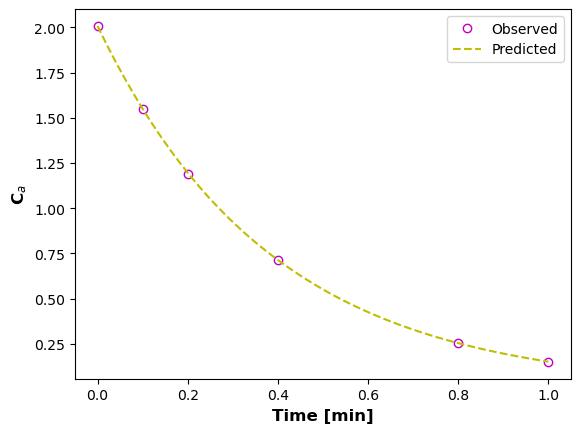

In [3]:
def y_calc(t, p):

    sol_ode = solve_ivp(lambda t, y, p: -p*y, 
                        (0, t[-1]), 
                        [Ca0], 
                        t_eval = t,
                        args = (p, ))

    return sol_ode.y[0]

# print(y_calc(tspan, 1))

# curve_fit(y_calc, t = tspan, y = Ca_data, p = p0)
params, kcov = curve_fit(y_calc, tspan, Ca_data, p0 = 1.3)

# unpack params
k = params

# find a sequence of inputs between the smallest and largest known inputs
tfit = np.linspace(min(tspan), max(tspan))

# calculate the output for the range
fit_y = y_calc(tfit, k)

fig = plt.subplots(dpi = 100)
plt.plot(tspan, Ca_data, 'mo', mfc = 'None', label='Observed')
plt.plot(tfit, fit_y, 'y--', label='Predicted')
plt.legend(loc='best')
plt.xlabel('Time [min]', fontsize=12, fontweight='bold')
plt.ylabel('C$_a$', fontsize=12, fontweight='bold')

print('The estimated value of rate constant is', k[0])

# 1st example with SLSQP

The estimated value of rate constant is 2.5899936560481516


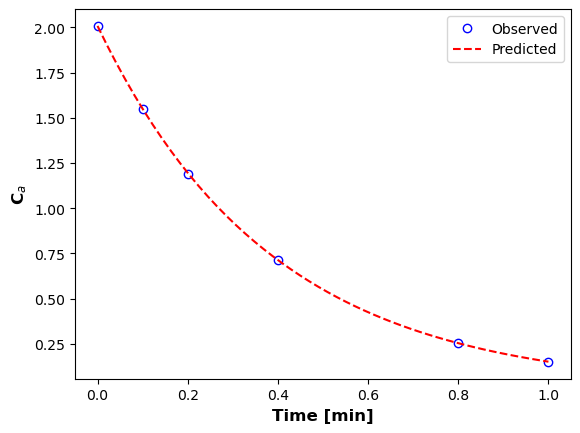

In [4]:
def y_calc(t, p):
    
    ode_sol = solve_ivp(lambda t, y, p: -p*y, 
                        (0, t[-1]), 
                        [Ca0], 
                        args=(p,), 
                        t_eval = t)
    
    return ode_sol.y[0]

min_fun = lambda p, t, y: sum((y_calc(t, p) - y)**2)

# args = (experimental values)
res_min = minimize(min_fun, 
               [1.3], # initial value of k
               args=(tspan, Ca_data), 
               method='SLSQP',
               bounds=[(0.0, np.inf)])

k = res_min.x
tfit = np.linspace(min(tspan), max(tspan))

# y_pred for the best parameter value
y_pred = y_calc(tfit, k)

plt.plot(tspan, Ca_data, "bo", mfc = 'None', label = 'Observed')
plt.plot(tfit, y_pred, "r--", label = 'Predicted')
plt.legend(loc='best')
plt.xlabel('Time [min]', fontsize=12, fontweight='bold')
plt.ylabel('C$_a$', fontsize=12, fontweight='bold')

print('The estimated value of rate constant is', k[0])

# 1st example with least_squares

The estimated value of rate constant is 2.5889197732081324


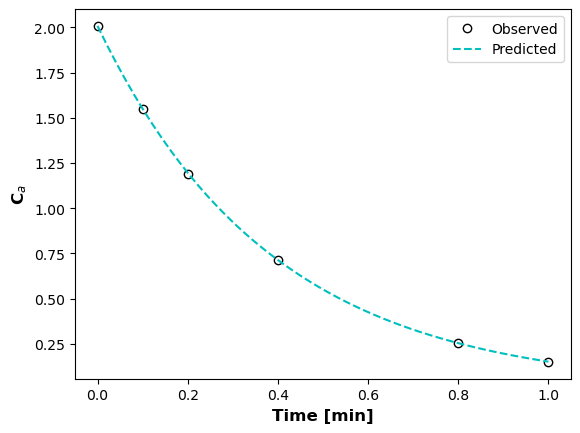

In [5]:
def y_calc(t, p):
    
    ode_sol = solve_ivp(lambda t, y, p: -p*y, 
                        (0, t[-1]), [Ca0], 
                        t_eval = t,
                        args = (p,))
    
    return ode_sol.y[0]


min_fun = lambda p, t, y: sum((y_calc(t, p) - y)**2)

# least_squares(min_fun, p = p0, bnds, args = (t = tspan, y = Ca_data)) - arguments of lambda follow the same order p, t, y
res_lsq = least_squares(min_fun, 
                        [2.5], 
                        bounds = (0.0, np.inf), 
                        args = (tspan, Ca_data))

k = res_lsq.x
tfit = np.linspace(min(tspan), max(tspan))

# y_pred for the best parameter value
y_pred = y_calc(tfit, k)

plt.plot(tspan, Ca_data, "ko", mfc = 'None', label = 'Observed')
plt.plot(tfit, y_pred, "c--", label = 'Predicted')
plt.legend(loc='best')
plt.xlabel('Time [min]', fontsize=12, fontweight='bold')
plt.ylabel('C$_a$', fontsize=12, fontweight='bold')

print('The estimated value of rate constant is', k[0])

# 2nd example with curve_fit (fake data)

b=0.02080777002317896, y0 = 0.9923419559637908


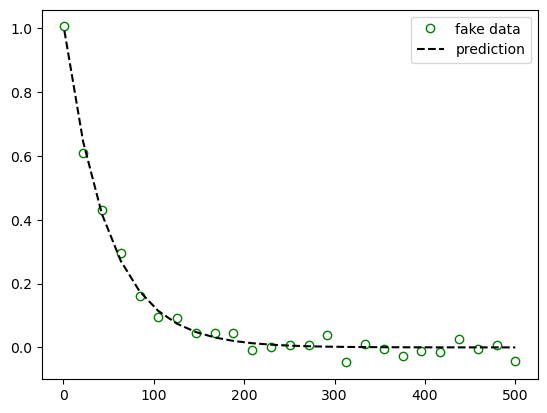

In [8]:
# when we have more than 1 parameter to optimize use *
def curve(t, *p):
    
    b, y0 = p

    sol = solve_ivp(lambda t, y, b: -b*y,
                   (xmin, xmax), 
                   [y0], 
                   t_eval= t,
                   args = (b,)) # we only care about the argument of the ode
    
    return sol.y[0]

xmin, xmax = 1, 500
n_points = 25 # here we can see that a significant lower number of points are needed in comparison to least_squares method

xdata = np.linspace(xmin, xmax, n_points)
ydata = np.exp(-0.02*xdata)+0.02*np.random.randn(*xdata.shape)

y0 = 5
b= 0.005
p0 = [b, y0]

popt, pcov = curve_fit(curve, xdata, ydata, p0=p0)
b, y0 = popt

print(f"b={b}, y0 = {y0}")

plt.plot(xdata, ydata, 'go', mfc = 'none', label = 'fake data')
plt.plot(xdata, curve(xdata, b, y0), 'k--', label = 'prediction')
plt.legend()

# 2nd example with least_squares (fake data)

b=0.019756588855467928, y0 = 0.9749874224885744


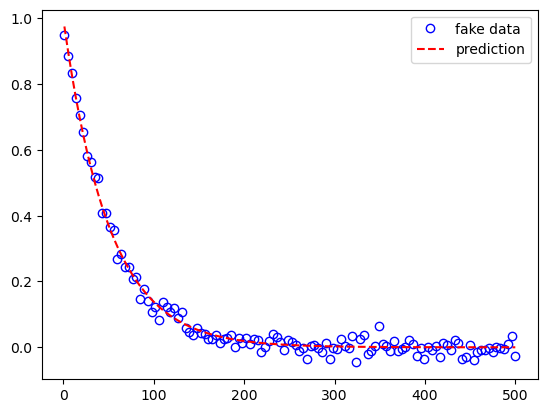

In [10]:
# when we have more than 1 parameter to optimize use * for unpacking
def curve(t, *p):
    
    b, y0 = p

    sol = solve_ivp(lambda t, y, b: -b*y,
                   (xmin, xmax), 
                   [y0], 
                   t_eval= t,
                   args = (b,)) # argument existed in ode
    
    return sol.y[0]

xmin, xmax = 1, 500
n_points = 120 # note that more points are needed in order to fit the curve in comparison to curve_fit

xdata = np.linspace(xmin, xmax, n_points)
ydata = np.exp(-0.02*xdata)+0.02*np.random.randn(*xdata.shape)

y0 = 5
b= 0.005
p0 = [b, y0]

res_lsq = least_squares(lambda p, t, y: sum((curve(t, *p) - y)**2), 
                        p0,
                        bounds = ([0, 0], np.inf),
                        args = (xdata, ydata))

b, y0 = res_lsq.x

print(f"b={b}, y0 = {y0}")

plt.plot(xdata, ydata, 'bo', mfc = 'none', label = 'fake data')
plt.plot(xdata, curve(xdata, b, y0), 'r--', label = 'prediction')
plt.legend()